## Dataset pre-processing

### 1. load dataset

In [1]:
import pandas as pd
import json
import codecs
import gzip

import os
file_list = os.listdir('./data')

# load dataset.
data = []
for f in file_list:
    file_path = 'data/'+f
    if file_path.endswith('.gz'): 
        with gzip.GzipFile(file_path, 'r') as gz:
            for text in gz:
                data.append(json.loads(text))
    
# load labels.
labels = []
with open('data/TRECIS_2018_2019-labels.json', 'r') as f:
    for i in json.load(f):
        labels.append(i)

In [2]:
# some data are not labeled. 
print("the size of dataset: ",len(data))
print("the size of labeled dataset: ", len(labels))

the size of dataset:  50490
the size of labeled dataset:  38478


In [3]:
labels[0] # 'postID'.

{'eventID': 'joplinTornado2011',
 'eventName': '2011 Joplin Tornado',
 'eventDescription': "The 2011 Joplin tornado was a catastrophic EF5-rated multiple-vortex tornado that struck Joplin, Missouri, late in the afternoon of Sunday, May 22, 2011. The user is a response officer in the Missouri command and control center responsible for impact to the state. <a href='https://en.wikipedia.org/wiki/2011_Joplin_tornado' target='_blank'>Wikipedia Page<a>",
 'eventType': 'Unknown',
 'postID': '72676276212731904',
 'postCategories': ['Factoid', 'Hashtags', 'News'],
 'postPriority': 'Low'}

In [4]:
print("id: ", data[0]['allProperties']['docno'])
print("content: ", data[0]['allProperties']['content'])

id:  230634706436227073
content:  Philippine floods worsen as death toll hits 14 in wake of ‘Gener’ http://t.co/gnhkYRS6 #Philippines #national


In [5]:
# match labels and data.
labels_dict = dict()

for i, l in enumerate(labels):
    labels_dict[l['postID']] = i

In [6]:
# construct dataset dataframe.
raw_label_dataset = pd.DataFrame(columns=['content', 'categories', 'priority'])
raw_unlabel_dataset = pd.DataFrame(columns=['content', 'categories', 'priority'])

for doc in data:
    doc_id, doc_cont = doc['allProperties']['docno'], doc['allProperties']['content']
    if doc_id not in labels_dict: 
        raw_unlabel_dataset = raw_unlabel_dataset.append({'content': doc_cont, 'categories': None, 'priority': None}, ignore_index=True)
    else:
        index = labels_dict[doc_id]
        raw_label_dataset = raw_label_dataset.append({'content': doc_cont, 'categories': labels[index]['postCategories'], 'priority': labels[index]['postPriority']}, ignore_index=True)


In [7]:
print("size of label dataset: ", len(raw_label_dataset))
print("size of unlabel dataset: ", len(raw_unlabel_dataset))

size of label dataset:  37373
size of unlabel dataset:  13117


### 2. data cleaning

In [8]:
import numpy as np
import re
import nltk
import emoji

from nltk.stem import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from tqdm.notebook import tqdm

nltk.download('wordnet')

stopwords = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zhangyingji/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
def remove_emoji(text):
    return emoji.get_emoji_regexp().sub(u'', text)

In [10]:
url_pattern = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
username_pattern = r"@[^\s]+"
hashtag_pattern = r"\B#\w\w+"

In [11]:
def text_processor(df):
    
    df_new = pd.DataFrame(columns=['content', 'categories', 'priority'])
    for i in tqdm(range(len(df))):
        
        content, categories, priority = df.loc[i, 'content'], df.loc[i, 'categories'], df.loc[i, 'priority']
        
        # remove url.
        content_url = re.sub(url_pattern, "", content)
        
        # remove @username. 
        content_username = re.sub(username_pattern, "", content_url)
    
        # remove #hashtag.
        content_hashtag = re.sub(hashtag_pattern, "", content_username)
        
        # lower case.
        content_lower = content_hashtag.lower()
        
        # tokenisation.
        token_list = RegexpTokenizer(pattern="\w+").tokenize(content_lower)
        
        # split words connected by hyphen.
        text = str()
        for i in token_list:
            text += i.replace("-", " ")
            text += " "
        token_list = word_tokenize(text)
        
        # POS.
        token_words = pos_tag(token_list)
        
        # WordNetLemmatizer
        words_lematizer = []
        wordnet_lematizer = WordNetLemmatizer()
        
        for word, tag in token_words:
            if tag.startswith('NN'):
                word_lematizer =  wordnet_lematizer.lemmatize(word, pos='n')  
            elif tag.startswith('VB'): 
                word_lematizer =  wordnet_lematizer.lemmatize(word, pos='v')  
            elif tag.startswith('JJ'): 
                word_lematizer =  wordnet_lematizer.lemmatize(word, pos='a')  
            elif tag.startswith('R'): 
                word_lematizer =  wordnet_lematizer.lemmatize(word, pos='r')
            else: 
                word_lematizer =  wordnet_lematizer.lemmatize(word)
            words_lematizer.append(word_lematizer)
            
        # remove stop words.
        cleaned_words = [word for word in words_lematizer if word.lower() not in stopwords]
        
        # remove punctuation.
        characters = [',','’', '\'','.','DBSCAN', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%','-','...','^','{','}','"']
        words_lists = [word for word in cleaned_words if word not in characters]
        text = str()
        for w in words_lists:
            text+=w
            text+=" "
            
        # remove emoji
        final_content = remove_emoji(text)
        df_new = df_new.append({'content': final_content, 'categories': categories, 'priority': priority}, ignore_index=True)
        
    return df_new


In [12]:
new_label_dataset = text_processor(raw_label_dataset)
new_unlabel_dataset = text_processor(raw_unlabel_dataset)

In [13]:
print("* dataset before cleaning: ")
print(raw_label_dataset.loc[2, 'content'])
print(" ")
print("* dataset after cleaning: ")
print(new_label_dataset.loc[2, 'content'])

* dataset before cleaning: 
4 Luzon dams release water; flood warning up: MANILA, Philippines - Four dams in Luzon opened their gates Sunday... http://t.co/kmWDCBFw
 
* dataset after cleaning: 
4 luzon dam release water flood warn up manila philippine four dam luzon open gate sunday 


### 3. dataset distribution ( balance or not )

In [14]:
# ccounting the number of each category and priority.

cat_dict, prior_dict = dict(), dict()

for i in range(len(labels)):
    cat, prior = labels[i]['postCategories'], labels[i]['postPriority']
    for c in cat:
        if c not in cat_dict:
            cat_dict[c] = 1
        else:
            cat_dict[c] += 1
    if prior not in prior_dict:
        prior_dict[prior] = 1
    else:
        prior_dict[prior] += 1

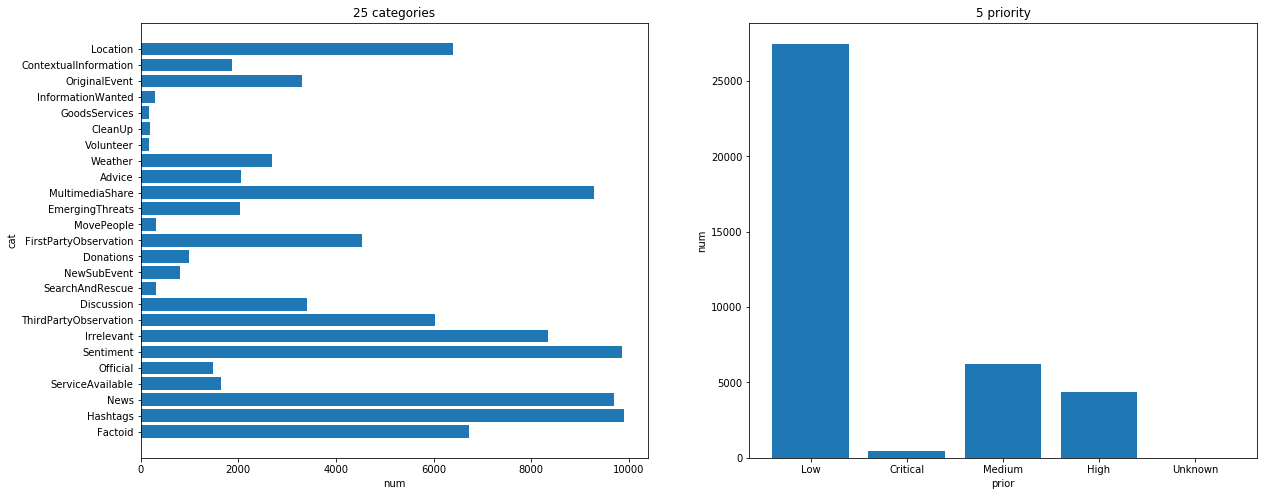

In [21]:
import matplotlib.pyplot as plt
cat, cat_num = list(cat_dict), list(cat_dict.values())
prior, prior_num = list(prior_dict), list(prior_dict.values())

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.barh(cat,cat_num)
plt.xlabel("num")
plt.ylabel("cat")
plt.title(str(len(cat))+" categories")
plt.subplot(1, 2, 2)
plt.bar(prior,prior_num)
plt.xlabel("prior")
plt.ylabel("num")
plt.title(str(len(prior))+" priority")
plt.show()

In [16]:
"""25 information type for multi-label tweet classification, four priorities for multi-class tweets classification."""

'25 information type for multi-label tweet classification, four priorities for multi-class tweets classification.'

### 4. convert "categories" and "priority" column to vector

In [17]:
cat_id, prior_id = [i for i in range(len(cat))], [i for i in range(len(prior))]
id_to_cat, id_to_prior = dict(zip(cat, cat_id)), dict(zip(prior, prior_id))

for i in tqdm(range(len(new_label_dataset))):
    temp_cat, temp_prior = new_label_dataset.loc[i, 'categories'], new_label_dataset.loc[i, 'priority']
    vec_cat, vec_prior = np.zeros(len(cat)), np.zeros(len(prior))
    for index in temp_cat: 
        vec_cat[id_to_cat[index]] = 1
        
    vec_prior[id_to_prior[temp_prior]] = 1
    new_label_dataset.loc[i, 'categories'] = vec_cat
    new_label_dataset.loc[i, 'priority'] = vec_prior
        

In [18]:
new_label_dataset[:5]

,content,categories,priority
0,philippine flood worsen death toll hit 14 wake...,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0]"
1,philippine flood fatality hit 23,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0]"
2,4 luzon dam release water flood warn up manila...,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0]"
3,rt pagasa 8 50pm advisory yellow warning metro...,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0]"
4,rt pagasa 4am advisory green warning metro man...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0]"


In [20]:
new_label_dataset.to_csv('new_label_dataset.csv')
new_unlabel_dataset.to_csv('new_unlabel_dataset.csv')